# Introduction
* This notebook contains an implementation of facial keypoint detection using Keras.
* The data I used for this project is the "facial keypint detection" competition, from kaggle: https://www.kaggle.com/c/facial-keypoints-detection.
* The data contains images (train and test) and 30 types of keypoints labels for the train data only, that the model will learn to predict for the test images.
* In the beginning, I built for this task a CNN model inspired by the architecture of the VGG16 model. After seeing that it was too slow for my computer, I removed many layers from the model. It still took about 10 hours to train the model with 20 epochs. I believe that with a deeper model, and with more training hours, the model would have achieved a more accurate result.

### The notebook is divided into the following parts:
* [Part 1: Notebook preparation](#part_1)
    * [Import](#import)
    * [Config](#config)
    * [Functions](#functions)
* [Part 2: Data preparation](#part_2)
* [Part 3: Modeling](#part_3)
* [Part 4: Predict the test data and make submission](#part_4)

<a id="part_1"></a>
# Part 1: Notebook preparation

<a id="import"></a>
## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output

from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, Flatten, Activation, Convolution2D, BatchNormalization, MaxPool2D
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam

<a id="config"></a>
## Config

In [2]:
trainFileName = 'training.csv'
testFileName = 'test.csv'
lookidFileName = 'IdLookupTable.csv'

train_data = pd.read_csv(trainFileName)  
test_data = pd.read_csv(testFileName)
lookid_data = pd.read_csv(lookidFileName)

<a id="functions"></a>
## Functions

In [3]:
def data_processing(data):
    imag = []
    for i in range(len(data)):
        img = data['Image'][i].split(' ')
        img = ['0' if x == '' else x for x in img]
        imag.append(img)

    image_list = np.array(imag,dtype = 'float')
    return image_list.reshape(-1,96,96,1)

In [4]:
def labels_processing(data):
    training = data.drop('Image',axis = 1)

    y_train = []
    for i in range(len(training)):
        y = training.iloc[i,:]
        y_train.append(y)

    return np.array(y_train,dtype = 'float')

In [5]:
def plot_images_with_keypoints(X_train, y_train):

    def plot_sample(x, y, axis):
        plt.imshow(x.reshape(96,96),cmap='gray')
        axis.scatter(y[0::2], y[1::2], marker='x', s=10)

    fig, axis = plt.subplots(2,3)    

    for i in range(6):
        axis = plt.subplot(2,3,i+1)
        ipic = np.random.choice(X_train.shape[0])
        plot_sample(X_train[ipic], y_train[ipic], axis)

    plt.subplots_adjust(top=1.5, bottom=0.08, left=0.10, right=2, hspace=0.25, wspace=0.35)
    plt.show()

In [6]:
def norm_std(X, mean=None, std=None):
    X = X.astype('float32')
    if (mean == None) & (std == None):
        mean, std = X.mean(), X.std()
    X = (X - mean) / std
    return X, mean, std

In [26]:
def CNN_model(n_labels, inputShape, modelName='Sequential Model'):
    
    model = Sequential()

    model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=inputShape))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())

    model.add(Convolution2D(128, (3,3),padding='same', use_bias=False))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(LeakyReLU(alpha = 0.1))
    model.add(Dropout(0.1))
    model.add(Dense(n_labels))
    
    model.name=modelName
    return model

In [9]:
def plot_loss(hist):
    plt.plot(hist.history['loss'] , 'g')
    plt.plot(hist.history['val_loss'] , 'b')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.grid(True)
    plt.show()

In [41]:
def make_submission_df(lookid_data, pred):
    
    lookid_list = list(lookid_data['FeatureName'])
    imageID = list(lookid_data['ImageId']-1)
    pre_list = list(pred)

    rowid = list(lookid_data['RowId'])

    feature = []
    for f in list(lookid_data['FeatureName']):
        feature.append(lookid_list.index(f))

    preded = []
    for x,y in zip(imageID,feature):
        preded.append(pre_list[x][y])

    rowid = pd.Series(rowid,name = 'RowId')
    loc = pd.Series(preded,name = 'Location')

    submission = pd.concat([rowid,loc],axis = 1)
    
    submission.loc[submission['Location']>96, 'Location'] = 96
    submission.loc[submission['Location']<0, 'Location'] = 0
    
    return submission

<a id="part_2"></a>
# Part 2: Data preparation

In [11]:
display(train_data.head(5).T)
print(f"Shape: {train_data.shape}")

,0,1,2,3,4
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949


Shape: (7049, 31)


In [12]:
train_data.isnull().any().value_counts()

True     28
False     3
dtype: int64

In [13]:
train_data.fillna(method = 'ffill',inplace = True)
train_data.isnull().any().value_counts()

False    31
dtype: int64

In [14]:
X_train = data_processing(train_data)
X_test = data_processing(test_data)

y_train = labels_processing(train_data)

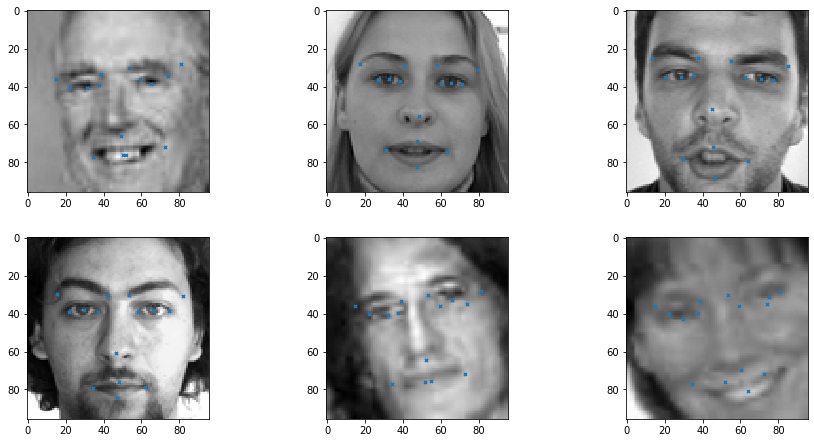

In [15]:
plot_images_with_keypoints(X_train, y_train)

In [16]:
X_train_scaled, mean, std = norm_std(X_train)
X_test_scaled, _, _ = norm_std(X_test, mean, std)

<a id="part_3"></a>
# Part 3: Modeling

In [27]:
inputShape = (96,96,1)
n_labels = y_train.shape[1]
model = CNN_model(n_labels, inputShape)

In [28]:
model.summary()

Model: "Sequential Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_14 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 48, 48, 32)   

In [29]:
opt_adam = Adam(clipnorm=1.0, clipvalue=0.5)
model.compile(optimizer=opt_adam,loss='mean_squared_error',metrics=['mae'])

In [30]:
hist = model.fit(X_train_scaled, y_train, epochs=20, batch_size=256, validation_split=0.2)

Train on 5639 samples, validate on 1410 samples
Epoch 1/20
5639/5639 [==============================] - 1579s 280ms/step - loss: 348.8994 - mean_absolute_error: 12.0462 - val_loss: 9914.8619 - val_mean_absolute_error: 91.0855
Epoch 2/20
5639/5639 [==============================] - 1521s 270ms/step - loss: 44.2627 - mean_absolute_error: 5.0752 - val_loss: 4261.4066 - val_mean_absolute_error: 59.5244
Epoch 3/20
5639/5639 [==============================] - 1579s 280ms/step - loss: 29.1780 - mean_absolute_error: 4.1662 - val_loss: 4483.7015 - val_mean_absolute_error: 60.5624
Epoch 4/20
5639/5639 [==============================] - 1600s 284ms/step - loss: 26.1839 - mean_absolute_error: 3.9200 - val_loss: 2092.2741 - val_mean_absolute_error: 41.9783
Epoch 5/20
5639/5639 [==============================] - 1494s 265ms/step - loss: 27.1976 - mean_absolute_error: 4.0430 - val_loss: 2556.0783 - val_mean_absolute_error: 46.8885
Epoch 6/20
5639/5639 [==============================] - 1454s 258ms/st

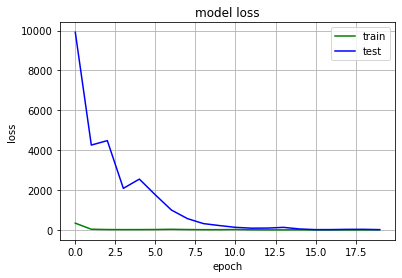

In [31]:
plot_loss(hist)

<a id="part_4"></a>
# Part 4: Predict the test data and make submission

In [32]:
pred = model.predict(X_test_scaled)

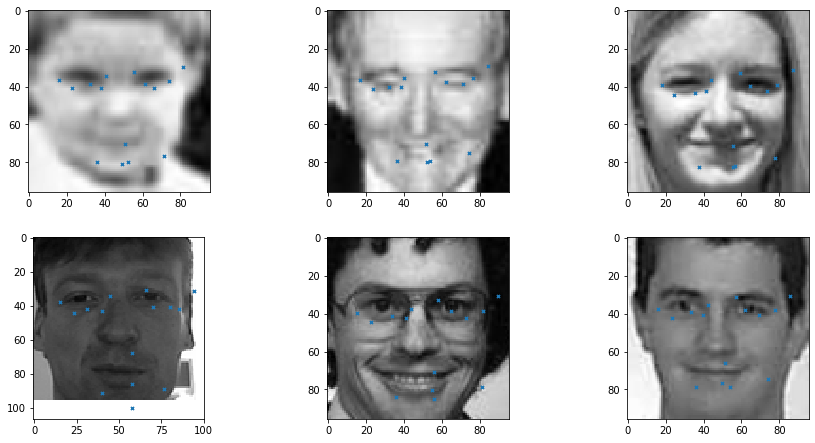

In [38]:
plot_images_with_keypoints(X_test, pred)

In [42]:
submission = make_submission_df(lookid_data, pred)
submission.to_csv('face_key_detection_submission.csv',index = False)